In [1]:
import numpy as np
import os
import sys
import time

import torch
from torch import nn, optim
import torch.nn.functional as F

import torchvision
from torchvision import transforms, models, datasets

from src.temperature_scaling import _ECELoss

import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
densenet121 = models.densenet121(pretrained=False)
densenet161 = models.densenet161(pretrained=False)

resnet18 = models.resnet18(pretrained=False)
resnet50 = models.resnet50(pretrained=False)

mobilenet = models.mobilenet_v2(pretrained=False)

In [5]:
densenet121.classifier = nn.Linear(in_features=1024, out_features=100, bias=True)
densenet161.classifier = nn.Linear(in_features=2208, out_features=100, bias=True)

resnet18.fc = nn.Linear(in_features=512, out_features=100, bias=True)
resnet50.fc = nn.Linear(in_features=2048, out_features=100, bias=True)

mobilenet.classifier[1] = nn.Linear(in_features=1280, out_features=100, bias=True)

In [6]:
densenet121 = densenet121.to(device)
densenet161 = densenet161.to(device)

resnet18 = resnet18.to(device)
resnet50 = resnet50.to(device)

mobilenet = mobilenet.to(device)

mdl_list = [densenet121, densenet161, resnet18, resnet50, mobilenet]

In [7]:
mean = [0.5071, 0.4867, 0.4408]
stdv = [0.2675, 0.2565, 0.2761]

train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=stdv),
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=stdv),
])

trainset = datasets.CIFAR100("data", train=True, transform=train_transforms, download=True)
testset = datasets.CIFAR100("data", train=False, transform=test_transforms, download=True)

bs = 64

train_loader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
def train(model, data_loader, seed=None, n_epochs=100, lr=0.1, momentum=0.9, verbose=False) :
    
    model.train()
    
    if seed is not None:
        torch.manual_seed(seed)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[0.5 * n_epochs, 0.75 * n_epochs], gamma=0.1)

    # Train model
    for epoch in range(1, n_epochs + 1):
        cum_loss = 0
        for i, (input, target) in enumerate(data_loader):
            # Forward pass
            input = input.to(device)
            target = target.to(device)
            output = model(input)
            loss = criterion(output, target)
            cum_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            optimizer.n_iters = optimizer.n_iters + 1 if hasattr(optimizer, 'n_iters') else 1
        
        if verbose :
            print(f"Epoch {epoch}/{n_epochs} : loss = {cum_loss}")
        scheduler.step()

    
    model.eval()

In [10]:
#Computes ECE for a given model on the test set
def model_ECE(model, data_loader) :
    ECE = _ECELoss()
    ece = 0
    for i, (input, target) in enumerate(data_loader) :
        input = input.to(device)
        target = target.to(device)
        logits = model(input)
        ece += ECE(logits, target).item()
    return ece

In [11]:
#Training and saving models, computing ECE for each model
n_epochs = 50
verbose = True

mdl_names = ["densenet121", "densenet161", "resnet18", "resnet50", "mobilenet"]
ece_list = []

save = 'model/'

for i in range(len(mdl_list)) :
    print(f"Training {mdl_names[i]}")
    train(mdl_list[i], train_loader, n_epochs=n_epochs, verbose=verbose)
    
    torch.save(mdl_list[i].state_dict(), os.path.join(save, mdl_names[i]+'.pth'))

    print("Computing ECE")
    ece_list.append(model_ECE(mdl_list[i], test_loader))

Training densenet121
Epoch 1/50 : loss = 3207.2453224658966
Epoch 2/50 : loss = 2754.3770654201508
Epoch 3/50 : loss = 2499.3237297534943
Epoch 4/50 : loss = 2358.896258831024
Epoch 5/50 : loss = 2166.0326356887817
Epoch 6/50 : loss = 2052.6442012786865
Epoch 7/50 : loss = 1969.2309172153473
Epoch 8/50 : loss = 1854.8364706039429
Epoch 9/50 : loss = 1755.730645775795
Epoch 10/50 : loss = 1681.9449656009674
Epoch 11/50 : loss = 1598.2708560228348
Epoch 12/50 : loss = 1530.8595118522644
Epoch 13/50 : loss = 1485.8525148630142
Epoch 14/50 : loss = 1405.51637673378
Epoch 15/50 : loss = 1388.021201491356
Epoch 16/50 : loss = 1303.1405799388885
Epoch 17/50 : loss = 1247.884159207344
Epoch 18/50 : loss = 1187.3003859519958
Epoch 19/50 : loss = 1143.8307207226753
Epoch 20/50 : loss = 1086.5480323433876
Epoch 21/50 : loss = 1055.506002008915
Epoch 22/50 : loss = 999.9021316766739
Epoch 23/50 : loss = 959.2671021223068
Epoch 24/50 : loss = 920.10444688797
Epoch 25/50 : loss = 886.9815218448639
E

No handles with labels found to put in legend.


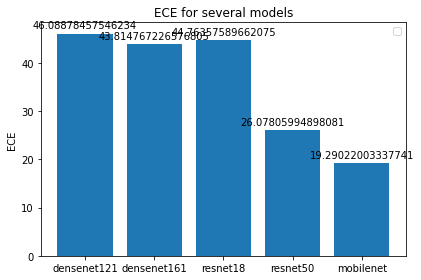

In [13]:
#Plotting a bar chart to compare ECE
x = np.arange(len(mdl_names))

fig, ax = plt.subplots()
ece_bar = ax.bar(x, ece_list)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('ECE')
ax.set_title('ECE for several models')
ax.set_xticks(x)
ax.set_xticklabels(mdl_names)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(ece_bar)

fig.tight_layout()

plt.show()